In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten,MaxPool2D,Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import itertools

originPath='D:\\ML\\jupyter\\github\\mnist-master\\DigitRecognizer\\'
train_data=pd.read_csv(originPath+'train.csv')
test_data=pd.read_csv(originPath+'test.csv')
batch_size = 256 # 在计算力允许的情况下，batch_size越大越好
nb_classes = 10
nb_epoch = 30

train_data.info()
print('_____________________________________________________')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
_____________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [9]:
print(train_data.isnull().any().describe())
print('_____________________________________________________')
print(test_data.isnull().any().describe())

count       785
unique        1
top       False
freq        785
dtype: object
_____________________________________________________
count       784
unique        1
top       False
freq        784
dtype: object


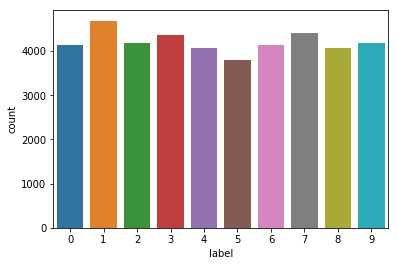

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


In [10]:
X_train=train_data.drop(columns=['label'])
Y_train=train_data.label
del train_data
# 绘制计数直方图
sns.countplot(Y_train)
plt.show()
# 使用pd.Series.value_counts()
print(Y_train.value_counts())

(42000, 28, 28, 1)
(28000, 28, 28, 1)
Train Sample: 42000
Test Sample: 28000


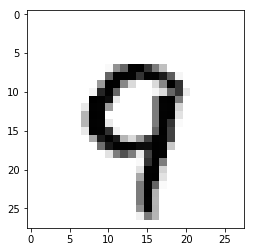

In [11]:
# 改变维度：第一个参数是图片数量，后三个参数是每个图片的维度
#由于mnist图片大小为28*28的灰度图，reshape第一个参数为-1可以自动填写图片的个数42000
X_train = X_train.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)
print(X_train.shape)
print(test_data.shape)
print("Train Sample:",X_train.shape[0])
print("Test Sample:",test_data.shape[0])
# 归一化：将数据进行归一化到0-1 因为图像数据最大是255
X_train = X_train/255.0
test_data = test_data/255.0
# 将类别向量(从0到nb_classes的整数向量)映射为二值类别矩阵
Y_train = to_categorical(Y_train, num_classes = nb_classes)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.1)
plt.imshow(X_train[0][:,:,0], cmap="Greys")
plt.show()

In [4]:
model = Sequential()
# filters：卷积核的数目（即输出的维度）
# kernel_size：卷积核的宽度和长度。如为单个整数，则表示在各个空间维度的相同长度。
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#压扁平，为全连接左准备
model.add(Flatten())
#添加256个节点进行全连接，指定relu为激活函数
model.add(Dense(256, activation = "relu"))
#dropout设置50%的保留率
model.add(Dropout(0.5))
#添加输出10个节点表示10个分类，用softmax来激活分类
model.add(Dense(10, activation = "softmax"))

In [5]:
#RMSprop是Geoff Hinton提出的一种自适应学习率方法，RMSprop仅仅是计算对应的平均值，因此可缓解Adagrad算法学习率下降较快的问题
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# 使用多类的对数损失categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
print("========fit start============")
history = model.fit(X_train,Y_train,
           batch_size=batch_size,
           epochs=nb_epoch,
           verbose=2,
           validation_data=(X_val,Y_val))
print("========fit finish============")

========fit start============
Train on 37800 samples, validate on 4200 samples
Epoch 1/100
 - 96s - loss: 0.4762 - acc: 0.8440 - val_loss: 0.1117 - val_acc: 0.9636
Epoch 2/100
 - 95s - loss: 0.1267 - acc: 0.9622 - val_loss: 0.0754 - val_acc: 0.9762
Epoch 3/100
 - 95s - loss: 0.0837 - acc: 0.9742 - val_loss: 0.0539 - val_acc: 0.9833
Epoch 4/100
 - 95s - loss: 0.0687 - acc: 0.9797 - val_loss: 0.0598 - val_acc: 0.9807
Epoch 5/100
 - 95s - loss: 0.0564 - acc: 0.9824 - val_loss: 0.0395 - val_acc: 0.9869
Epoch 6/100
 - 95s - loss: 0.0486 - acc: 0.9850 - val_loss: 0.0367 - val_acc: 0.9890
Epoch 7/100
 - 95s - loss: 0.0436 - acc: 0.9864 - val_loss: 0.0663 - val_acc: 0.9807
Epoch 8/100
 - 95s - loss: 0.0405 - acc: 0.9874 - val_loss: 0.0454 - val_acc: 0.9879
Epoch 9/100
 - 95s - loss: 0.0365 - acc: 0.9888 - val_loss: 0.0395 - val_acc: 0.9888
Epoch 10/100
 - 95s - loss: 0.0344 - acc: 0.9898 - val_loss: 0.0350 - val_acc: 0.9895
Epoch 11/100
 - 95s - loss: 0.0325 - acc: 0.9906 - val_loss: 0.0354 - 

Epoch 96/100
 - 94s - loss: 0.0314 - acc: 0.9943 - val_loss: 0.0543 - val_acc: 0.9919
Epoch 97/100
 - 94s - loss: 0.0329 - acc: 0.9944 - val_loss: 0.0537 - val_acc: 0.9914
Epoch 98/100
 - 94s - loss: 0.0372 - acc: 0.9938 - val_loss: 0.0646 - val_acc: 0.9917
Epoch 99/100
 - 94s - loss: 0.0381 - acc: 0.9942 - val_loss: 0.0606 - val_acc: 0.9921
Epoch 100/100
 - 94s - loss: 0.0403 - acc: 0.9933 - val_loss: 0.0517 - val_acc: 0.9907
========fit finish============


In [6]:
score = model.evaluate(X_val, Y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.05173542978749278
Val accuracy: 0.9907142857142858


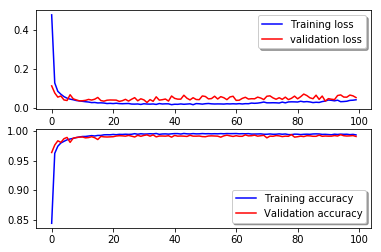

In [7]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
plt.show()

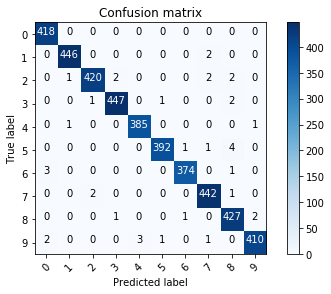

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="Blues"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 是否进行标准化
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# 根据验证集标签的真实值和预测值计算混淆矩阵（confusion_matrix）
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(Y_val,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# 绘制混淆矩阵
plot_confusion_matrix(confusion_mtx, classes = range(10))

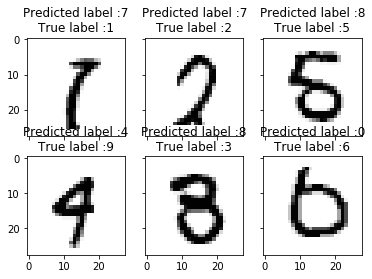

In [9]:
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap="Greys")
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.show()

errors = (Y_pred_classes - Y_true != 0)  # 矩阵相减得到误差集（?*1）
# 使用布尔索引
Y_pred_classes_errors = Y_pred_classes[errors]  # 误差集的预测标签Y（?*1）
Y_pred_errors = Y_pred[errors]  # 误差集的预测序列（?*10）
Y_true_errors = Y_true[errors]  # 误差集的真实标签Y（?*1）
X_val_errors = X_val[errors]  # 误差集的特征X，即数字图片（?*28*28*1）

# 误差集中对错误标签的预测概率
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
# 误差集中对真实标签的预测概率，np.diagonal是返回对角线的元素
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
# 排序并返回的是数组值从小到大的索引值
sorted_dela_errors = np.argsort(delta_pred_true_errors)
most_important_errors = sorted_dela_errors[-6:]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [10]:
# 用以生成一个batch的图像数据，支持实时数据提升
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [12]:
optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# 使用多类的对数损失categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs =nb_epoch, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size+1,
                              callbacks=[learning_rate_reduction])
print("=============model fit_generator finish=================")

Epoch 1/100
 - 98s - loss: 0.2953 - acc: 0.9371 - val_loss: 0.0543 - val_acc: 0.9900
Epoch 2/100
 - 96s - loss: 0.1932 - acc: 0.9552 - val_loss: 0.0428 - val_acc: 0.9924
Epoch 3/100
 - 96s - loss: 0.1556 - acc: 0.9626 - val_loss: 0.0406 - val_acc: 0.9898
Epoch 4/100
 - 96s - loss: 0.1388 - acc: 0.9678 - val_loss: 0.0299 - val_acc: 0.9924
Epoch 5/100
 - 96s - loss: 0.1282 - acc: 0.9688 - val_loss: 0.0381 - val_acc: 0.9914

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/100
 - 96s - loss: 0.1106 - acc: 0.9731 - val_loss: 0.0261 - val_acc: 0.9938
Epoch 7/100
 - 96s - loss: 0.0937 - acc: 0.9769 - val_loss: 0.0320 - val_acc: 0.9924
Epoch 8/100
 - 96s - loss: 0.0947 - acc: 0.9763 - val_loss: 0.0306 - val_acc: 0.9943
Epoch 9/100
 - 97s - loss: 0.0920 - acc: 0.9771 - val_loss: 0.0299 - val_acc: 0.9921
Epoch 10/100
 - 101s - loss: 0.0979 - acc: 0.9766 - val_loss: 0.0278 - val_acc: 0.9945
Epoch 11/100
 - 96s - loss: 0.0897 - acc: 0.9782 - val_loss: 0.0242

Epoch 90/100
 - 117s - loss: 0.0611 - acc: 0.9842 - val_loss: 0.0223 - val_acc: 0.9943
Epoch 91/100
 - 118s - loss: 0.0577 - acc: 0.9846 - val_loss: 0.0225 - val_acc: 0.9945
Epoch 92/100
 - 922s - loss: 0.0612 - acc: 0.9843 - val_loss: 0.0225 - val_acc: 0.9945
Epoch 93/100
 - 188s - loss: 0.0622 - acc: 0.9844 - val_loss: 0.0224 - val_acc: 0.9948
Epoch 94/100
 - 97s - loss: 0.0610 - acc: 0.9849 - val_loss: 0.0227 - val_acc: 0.9948
Epoch 95/100
 - 97s - loss: 0.0582 - acc: 0.9848 - val_loss: 0.0227 - val_acc: 0.9948
Epoch 96/100
 - 98s - loss: 0.0585 - acc: 0.9851 - val_loss: 0.0229 - val_acc: 0.9945
Epoch 97/100
 - 98s - loss: 0.0592 - acc: 0.9847 - val_loss: 0.0226 - val_acc: 0.9945
Epoch 98/100
 - 97s - loss: 0.0637 - acc: 0.9841 - val_loss: 0.0229 - val_acc: 0.9945
Epoch 99/100
 - 97s - loss: 0.0600 - acc: 0.9848 - val_loss: 0.0227 - val_acc: 0.9948
Epoch 100/100
 - 97s - loss: 0.0575 - acc: 0.9843 - val_loss: 0.0231 - val_acc: 0.9948


In [14]:
print('Begin to predict for testing data ...')
results = model.predict(test_data)
results = np.argmax(results,axis = 1) 
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv(originPath+"submit.csv",index=False)
print('End predict for testing data ...')

Begin to predict for testing data ...
